In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
from pathlib import Path
import json

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import cf_xarray as cfxr
import seaborn as sns
import cmocean

from lmrecon.io import open_mfdataset
from lmrecon.util import stack_state, unstack_state, to_math_order, to_cf_order, get_data_path
from lmrecon.plotting import plot_field, add_subplot_headers, format_plot
from lmrecon.stats import area_weighted_mean, rmse, average_seasonally, area_weighted_rmse
from lmrecon.lim import LIM
from lmrecon.spaces import PhysicalSpaceForecastSpaceMapper
from lmrecon.logger import logging_disabled

In [3]:
def load_run(id):
    rundir = Path(f"/home/enkf6/dstiller/lmrecon/reconstructions/{id}")
    return open_mfdataset(rundir / "posterior_mean")

In [25]:
recons_mpi = {
    32: "2024-07-01T13-04-20",
    24: "2024-07-01T13-28-24",
    16: "2024-07-01T13-14-30",
    8: "2024-07-01T14-04-46",
    6: "2024-07-15T16-14-23",  # 8 with minimal error
}
for k, v in recons_mpi.items():
    recons_mpi[k] = load_run(v)

In [5]:
recons_mri = {
    32: "2024-07-01T14-06-37",
    24: "2024-07-01T14-17-10",
    16: "2024-07-01T14-35-05",
    8: "2024-07-01T15-13-20",
}
for k, v in recons_mri.items():
    recons_mri[k] = load_run(v)

In [6]:
ds_mpi_8_3000km = open_mfdataset(Path(f"/home/enkf6/dstiller/lmrecon/reconstructions") / "2024-07-07T20-54-03" / "posterior_mean")

In [7]:
ds_mpi_8_8000km = open_mfdataset(Path(f"/home/enkf6/dstiller/lmrecon/reconstructions/2024-07-13T13-49-36/posterior_mean"))

In [23]:
mapper_id = "2024-07-13T20-38-28"
ver_mri = open_mfdataset(
    get_data_path() / "cmip6" / "seasonal" / "anomalies" / "MRI-ESM2-0" / "past1000" / "truncated" / mapper_id
    ).sel(time=recons_mri[32].time)
ver_mpi = open_mfdataset(
    get_data_path() / "cmip6_seasonal_anomalies/MPI-ESM1-2-LR/past2k"
    ).sel(time=recons_mpi[32].time, method="nearest")
ver_mpi = open_mfdataset(
    get_data_path() / "cmip6" / "seasonal" / "anomalies" / "MPI-ESM1-2-LR" / "past2k"  / "truncated" / mapper_id
    ).sel(time=recons_mpi[32].time, method="nearest")
ver_mpi["time"] = recons_mpi[32].time

In [17]:
area_weighted_rmse(ds_mpi_8_8000km, ver_mpi).compute()

<xarray.Dataset> Size: 1kB
Dimensions:  (time: 13)
Coordinates:
  * time     (time) float64 104B 1.24e+03 1.24e+03 ... 1.243e+03 1.243e+03
    season   (time) <U3 156B 'DJF' 'MAM' 'JJA' 'SON' ... 'MAM' 'JJA' 'SON' 'DJF'
Data variables:
    ohc700   (time) float64 104B 5.834e+08 3.919e+08 ... 6.63e+08 8.517e+08
    pr       (time) float64 104B 6.286e-06 7.612e-06 ... 6.803e-06 6.671e-06
    psl      (time) float64 104B 180.1 181.5 324.3 213.0 ... 255.8 198.2 235.5
    rlut     (time) float64 104B 3.675 5.35 5.075 4.351 ... 4.807 4.053 4.037
    rsut     (time) float64 104B 4.619 4.71 4.475 4.129 ... 4.758 3.997 4.245
    sos      (time) float64 104B 0.0001951 0.0001977 ... 0.0001408 0.00012
    tas      (time) float64 104B 0.7573 0.6823 0.6031 ... 0.6124 0.558 0.5278
    tos      (time) float64 104B 0.4552 0.3617 0.3757 ... 0.3247 0.3208 0.3096
    zg500    (time) float64 104B 18.77 22.26 32.1 23.52 ... 25.85 20.65 24.86
    zos      (time) float64 104B 0.02533 0.02042 0.03147 ... 0.02034 0.02017

In [8]:
def get_lim_baseline(ds_ver):
    lim = LIM.load(get_data_path() / "lim" / "2024-07-15T16-08-15" / "lim.pkl")
    mapper = PhysicalSpaceForecastSpaceMapper.load(get_data_path() / "reduced_space" / "2024-06-03T01-20-30" / "mapper.pkl")
    with logging_disabled():
        initial_condition = mapper.forward(to_math_order(stack_state(ver_mpi.isel(time=0))))
    forecast = lim.forecast_stochastic(initial_condition, len(ver_mpi.time) - 1, 1440 // 4, n_ensemble=100).isel(time=slice(1, None))
    with logging_disabled():
        return unstack_state(mapper.backward(forecast.stack(dict(sample=["time", "ens"]))).unstack("sample"))

ds_lim_baseline = get_lim_baseline(ver_mpi)

100%|██████████| 7201/7201 [00:03<00:00, 2149.23it/s]


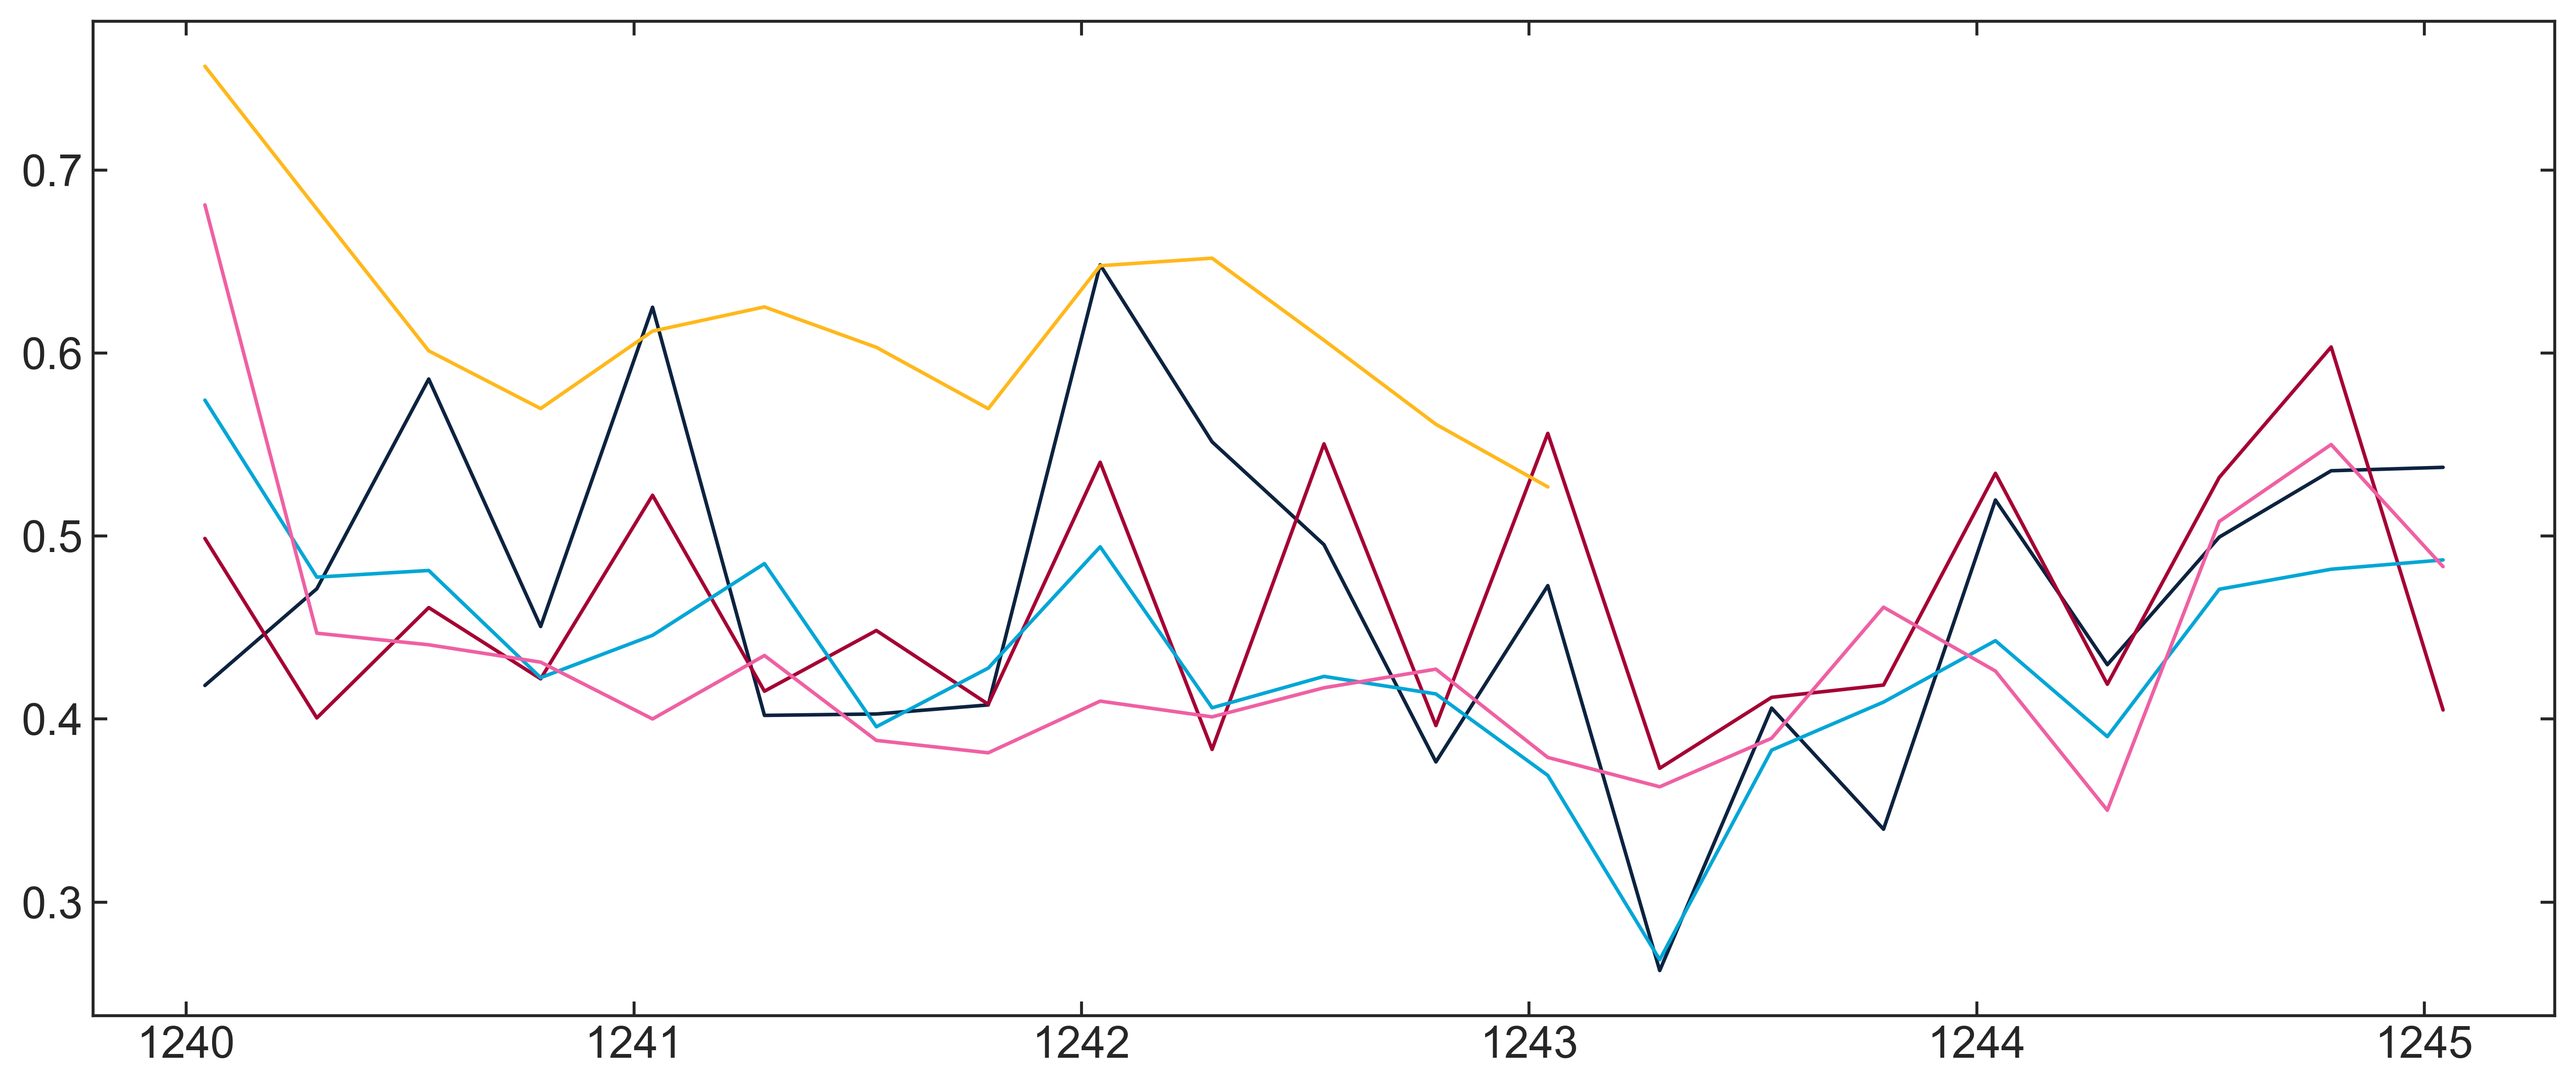

In [41]:
plt.plot(recons_mpi[32].time, area_weighted_rmse(recons_mpi[32]["tas"], ver_mpi["tas"]))
plt.plot(recons_mpi[24].time, area_weighted_rmse(recons_mpi[24]["tas"], ver_mpi["tas"]))
plt.plot(recons_mpi[16].time, area_weighted_rmse(recons_mpi[16]["tas"], ver_mpi["tas"]))
plt.plot(recons_mpi[8].time, area_weighted_rmse(recons_mpi[8]["tas"], ver_mpi["tas"]))
plt.plot(recons_mpi[7].time, area_weighted_rmse(recons_mpi[7]["tas"], ver_mpi["tas"]))

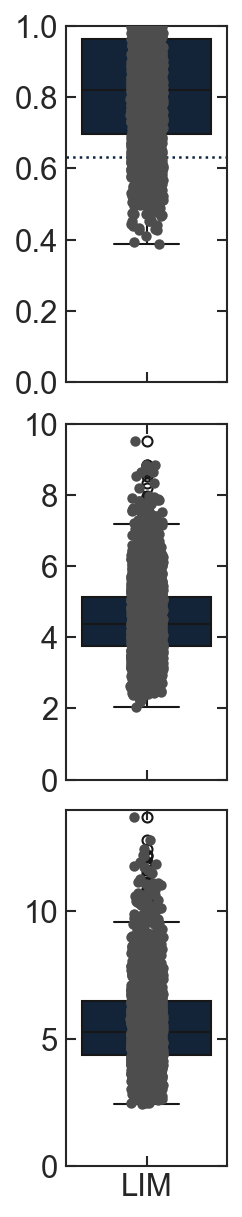

In [56]:
def plot_lim_baseline(ds, ver):
    fig, axs = plt.subplots(3, figsize=(1.5, 8), sharex=True, dpi=150)
    for ax, field, unit, vmax in zip(axs, ["tas", "rsut", "rlut"], ["K", "W/m²", "W/m²"], [1, 10, 14]):
        n_sample = len(ds.time) * len(ds.ens)
        sns.boxplot(x=[0] * n_sample, y=area_weighted_rmse(ver[field], ds[field]).values.flatten(), ax=ax)
        sns.stripplot(x=[0] * n_sample, y=area_weighted_rmse(ver[field], ds[field]).values.flatten(), ax=ax, color=".3")
        ax.set_ylim([0, vmax])
    axs[0].axhline(np.sqrt(0.4), ls=":")
    ax.set_xticks([0], ["LIM"])

plot_lim_baseline(ds_lim_baseline, ver_mpi)

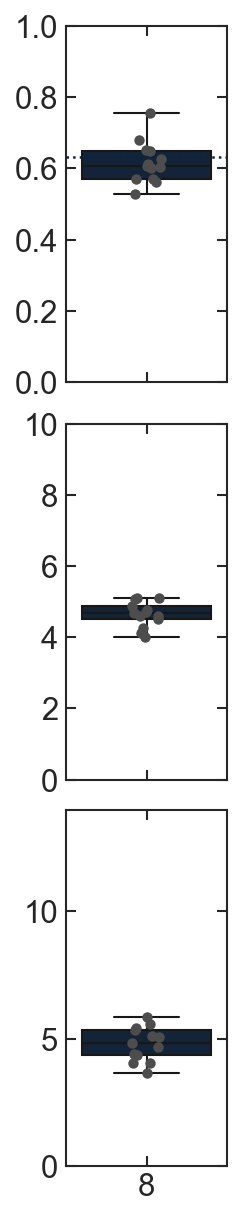

In [33]:
def plot_individual(ds, ver, name):
    fig, axs = plt.subplots(3, figsize=(1.5, 8), sharex=True, dpi=150)
    for ax, field, unit, vmax in zip(axs, ["tas", "rsut", "rlut"], ["K", "W/m²", "W/m²"], [1, 10, 14]):
        n_sample = len(ds.time)
        sns.boxplot(x=[0] * n_sample, y=area_weighted_rmse(ver[field], ds[field]).values, ax=ax)
        sns.stripplot(x=[0] * n_sample, y=area_weighted_rmse(ver[field], ds[field]).values, ax=ax, color=".3")
        ax.set_ylim([0, vmax])
    axs[0].axhline(np.sqrt(0.4), ls=":")
    ax.set_xticks([0], [name])

# plot_individual(ds_mpi_8_3000km, ver_mpi, "8")
plot_individual(ds_mpi_8_8000km, ver_mpi, "8")

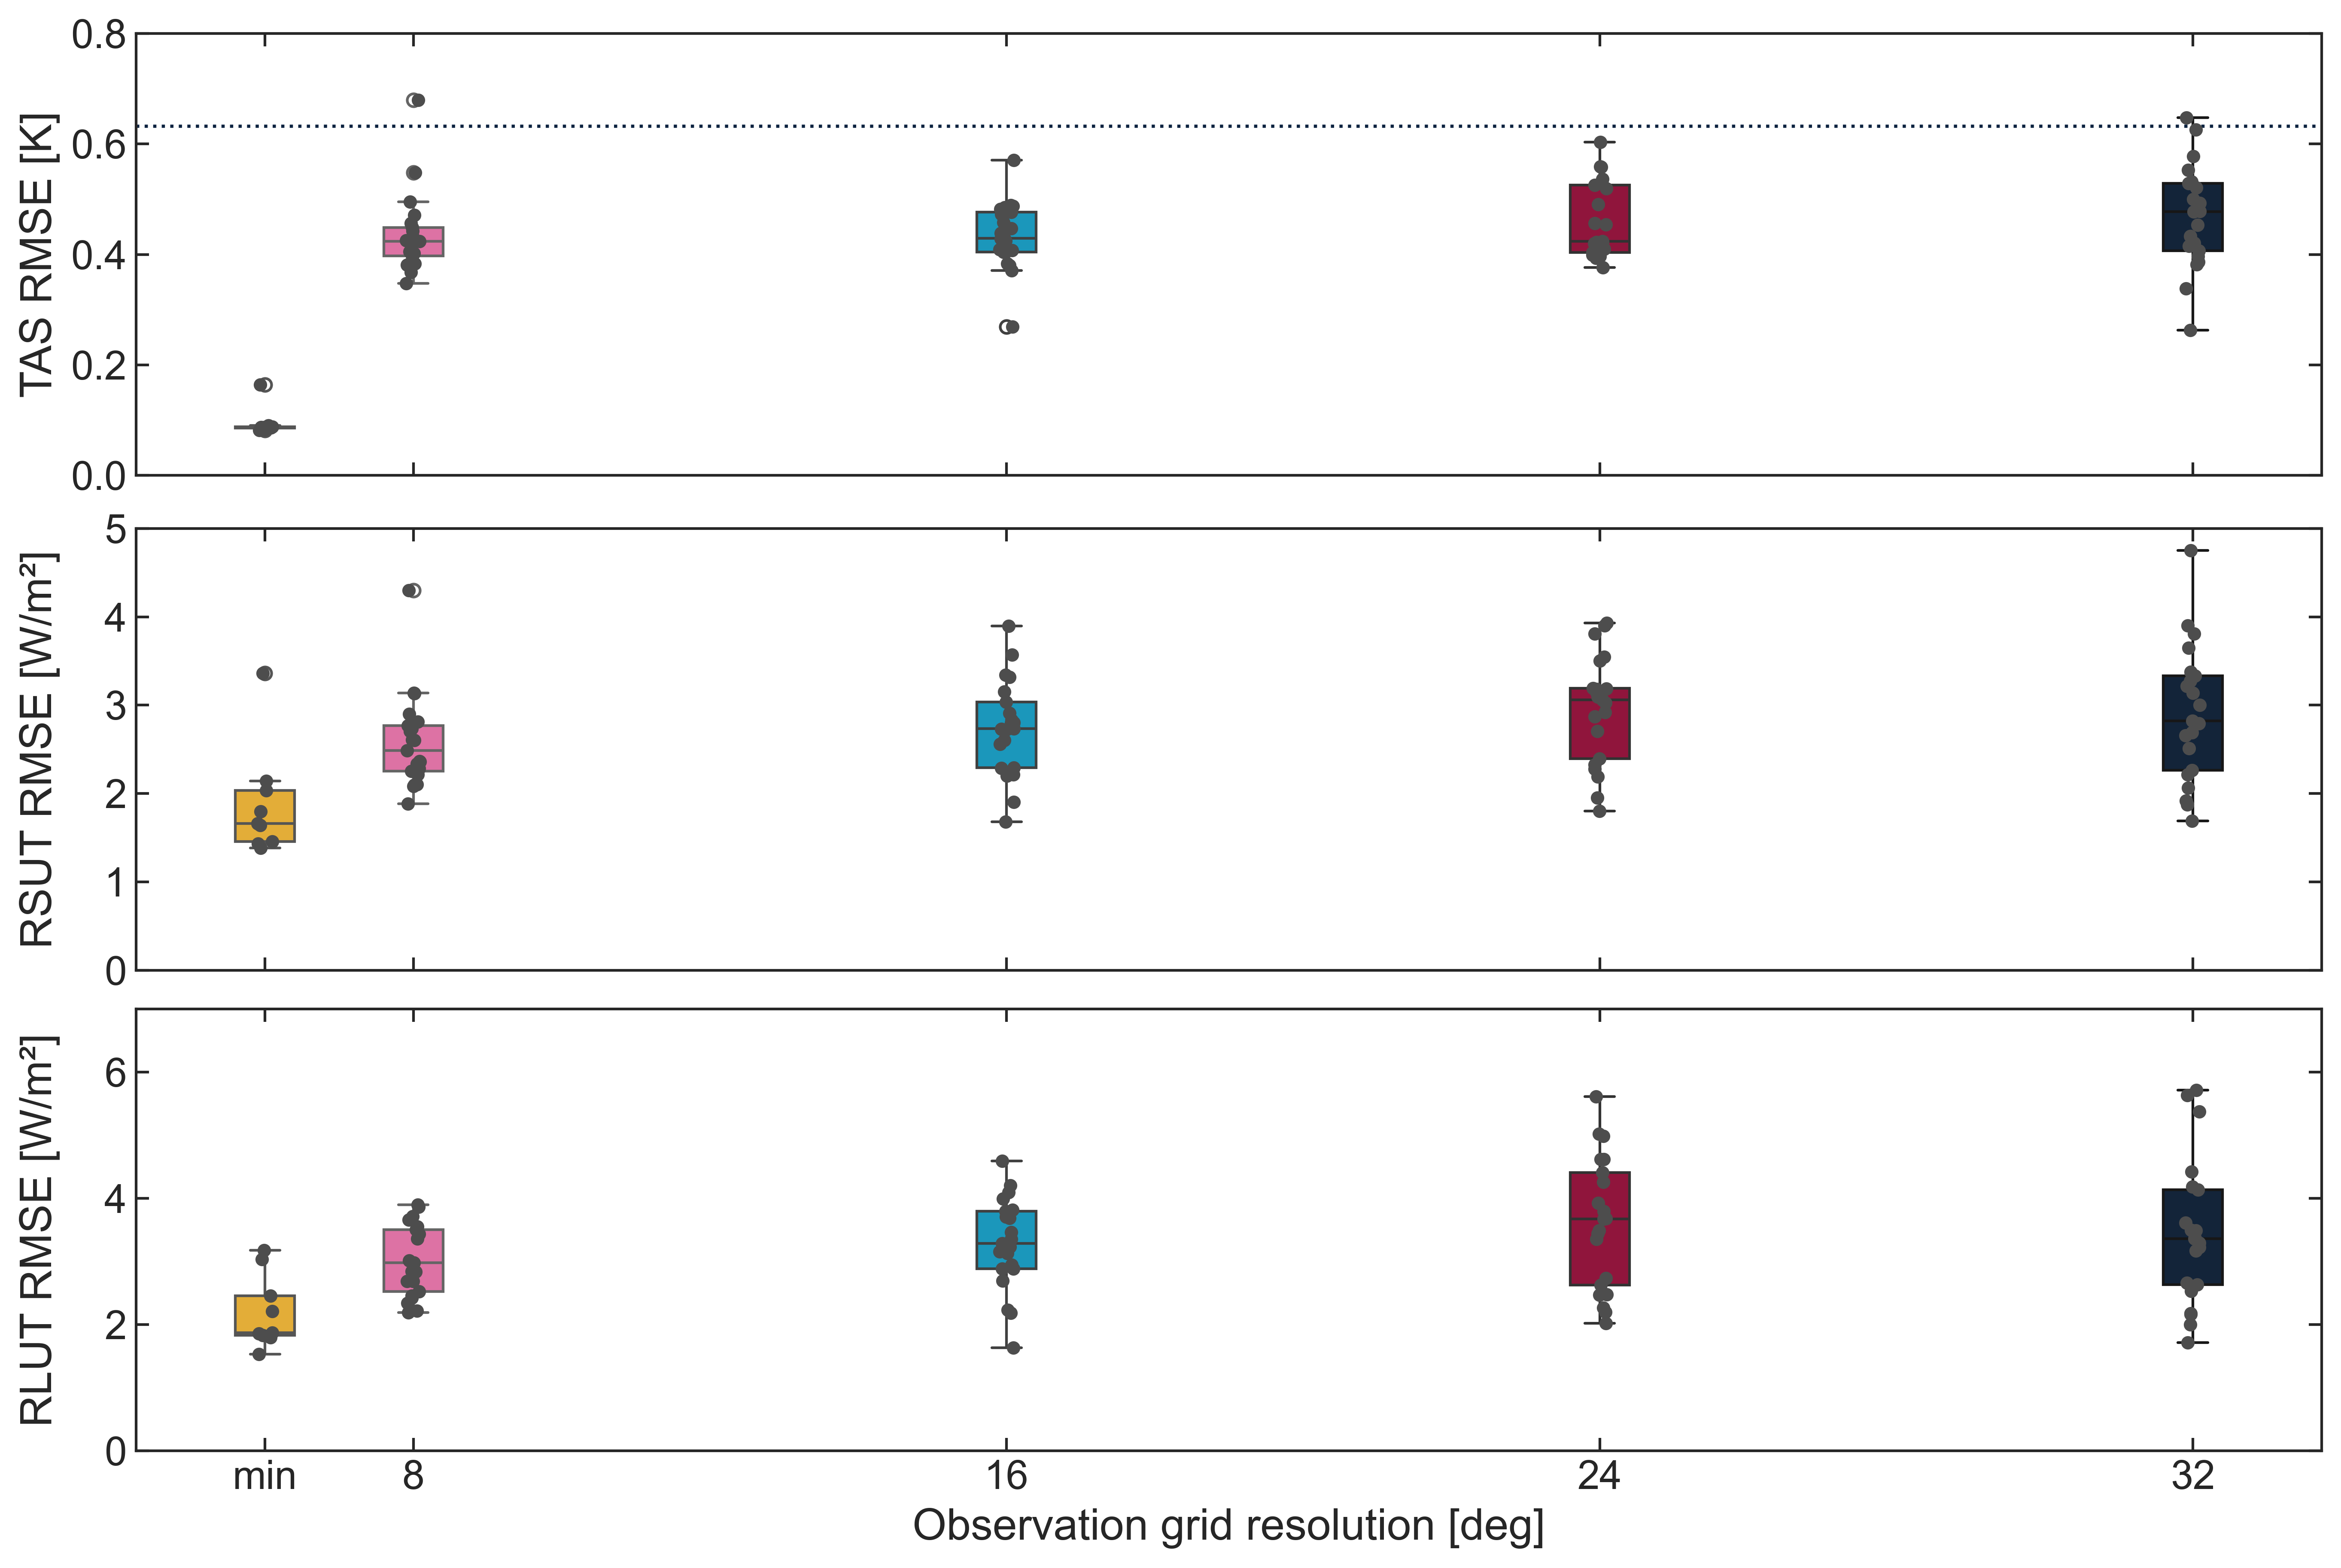

In [26]:
def plot_convergence(recons, ver):
    fig, axs = plt.subplots(3, figsize=(12, 8), sharex=True)

    for ax, field, unit, vmax in zip(axs, ["tas", "rsut", "rlut"], ["K", "W/m²", "W/m²"], [0.8, 5, 7]):
        for k, v in recons.items():
            sns.boxplot(x=[k] * len(v.time), y=area_weighted_rmse(v[field], ver[field]), ax=ax, native_scale=True)
            sns.stripplot(x=[k] * len(v.time), y=area_weighted_rmse(v[field], ver[field]), ax=ax, color=".3", native_scale=True)
        ax.set_ylabel(f"{field.upper()} RMSE [{unit}]")
        ax.set_ylim([0, vmax])
    axs[-1].set_xlabel("Observation grid resolution [deg]")
    axs[0].axhline(np.sqrt(0.4), ls=":")

    format_plot()
    for ax in axs:
        ax.set_xticks(list(recons.keys()), labels=["32", "24", "16", "8", "min"])

plot_convergence(recons_mpi, ver_mpi)
# plot_convergence(recons_mri, ver_mri)

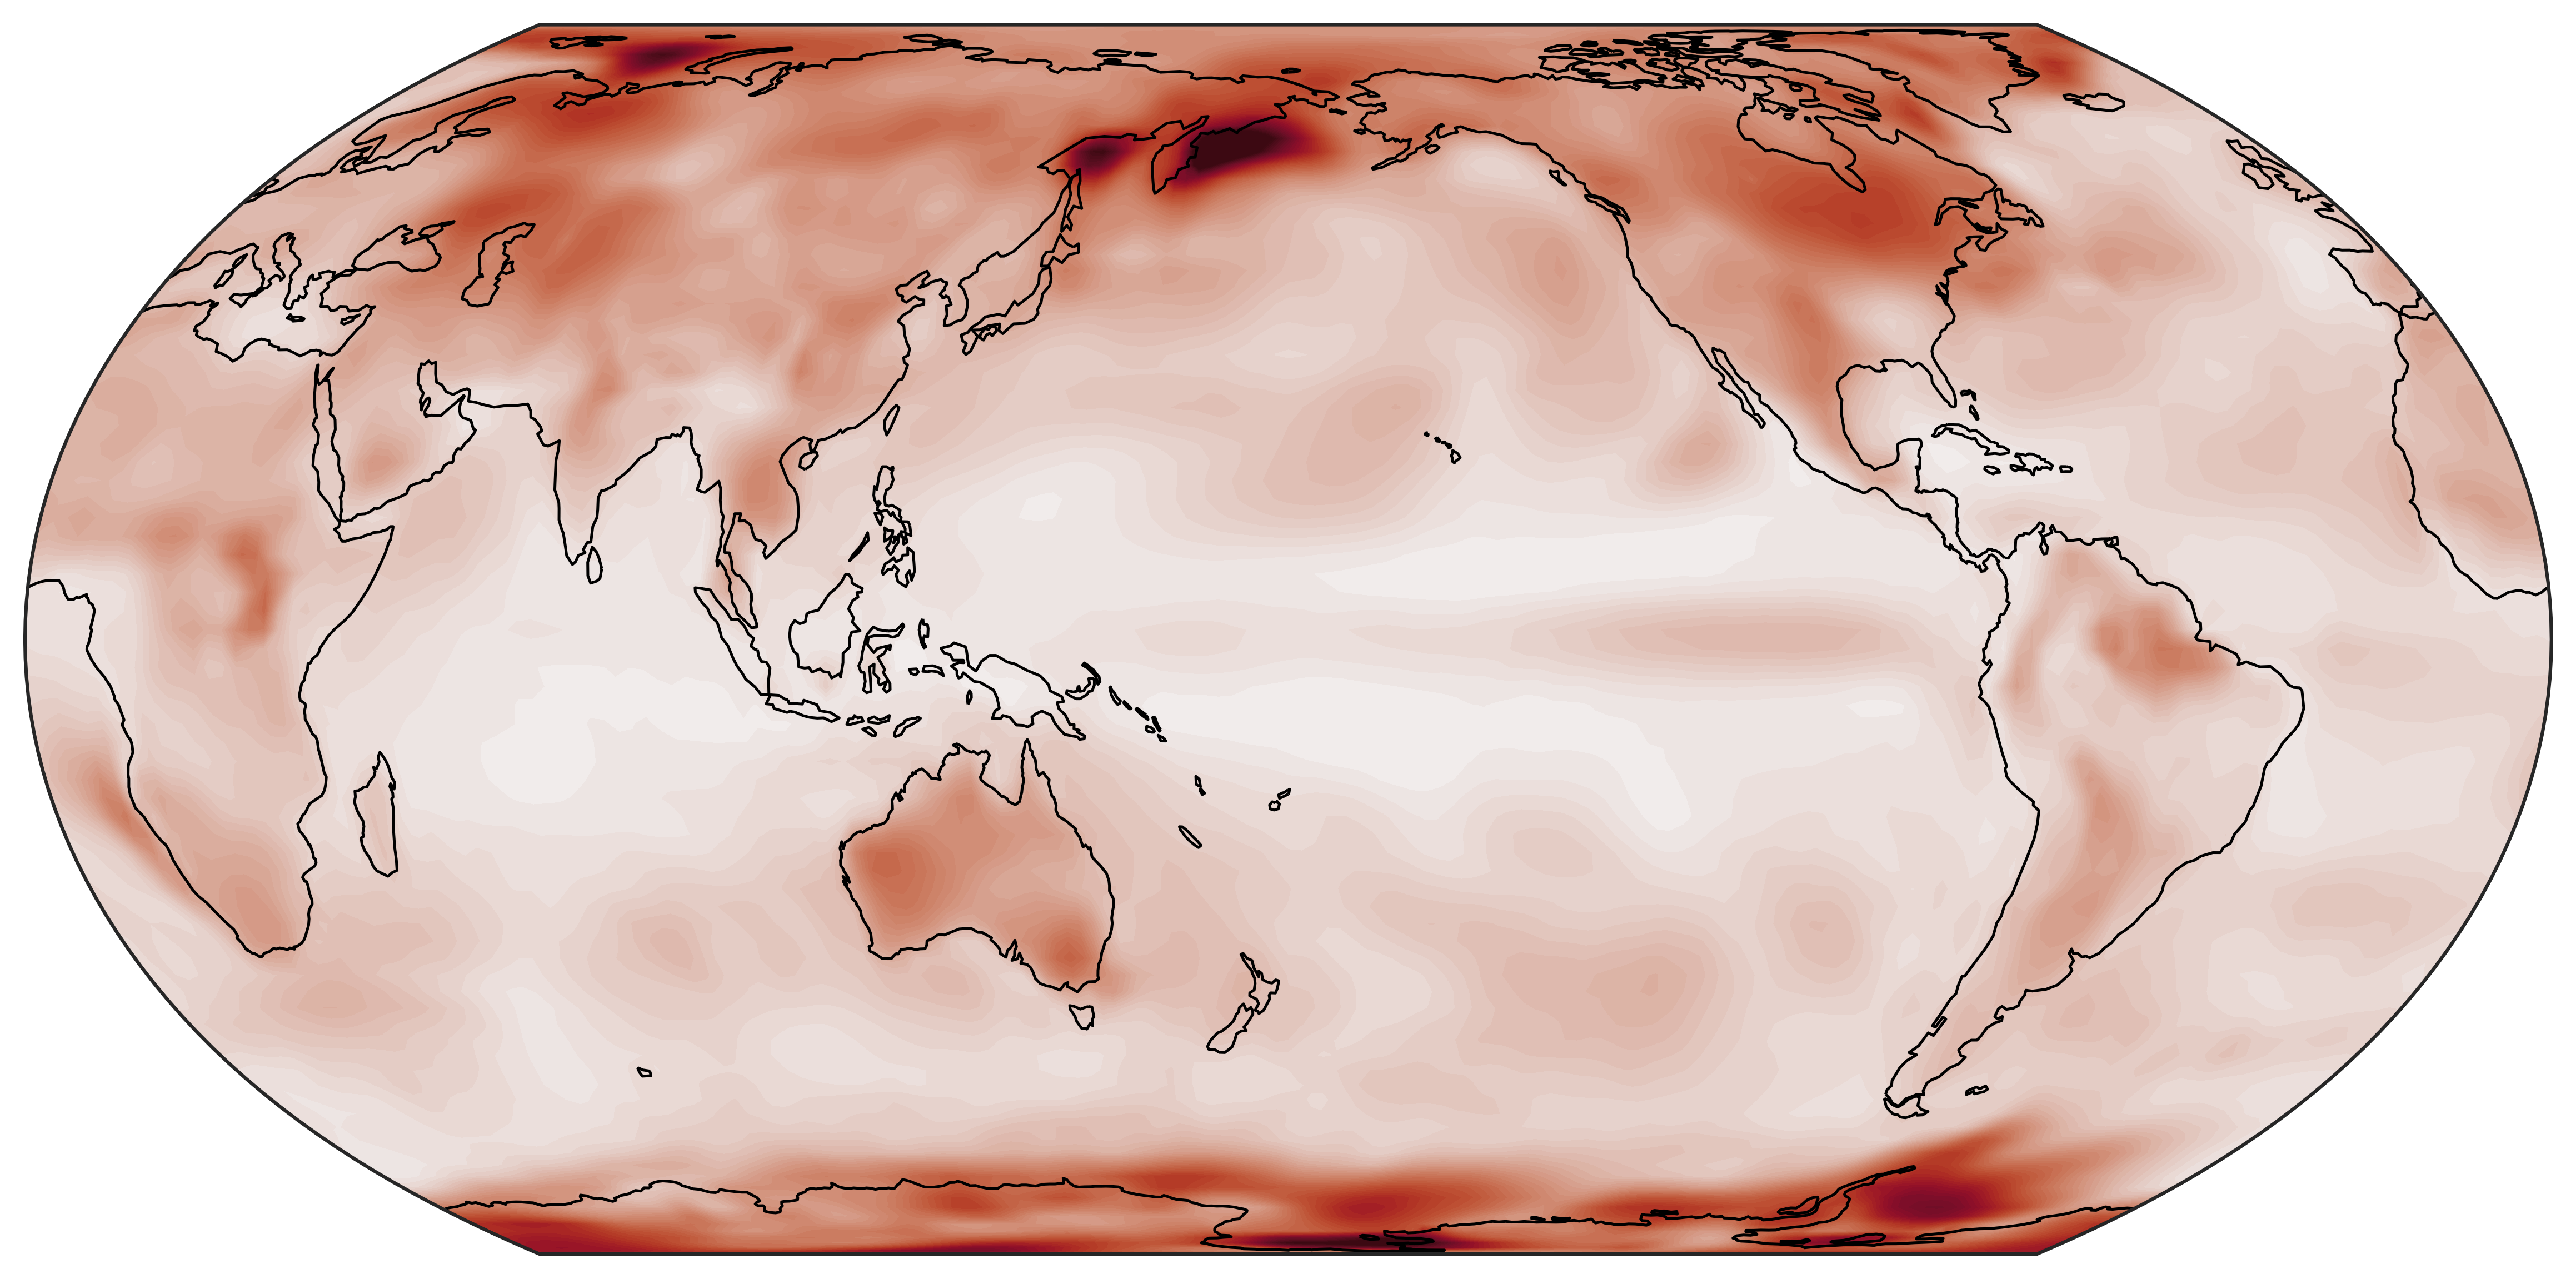

In [40]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)))
plot_field(ax, rmse(ds_mpi_8_8000km["tas"], ver_mpi["tas"], "time"),
           cmap=cmocean.cm.amp, same_limits=False, vmin=0, vmax=2.5, colorbar=False)
ax.coastlines()

/home/disk/p/dstiller/.local/software/miniconda3/envs/lmrecon/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/disk/p/dstiller/.local/software/miniconda3/envs/lmrecon/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/disk/p/dstiller/.local/software/miniconda3/envs/lmrecon/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/disk/p/dstiller/.local/software/miniconda3/envs/lmrecon/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/disk/p/dstiller/.local/software/miniconda3/envs/lmrecon/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divid

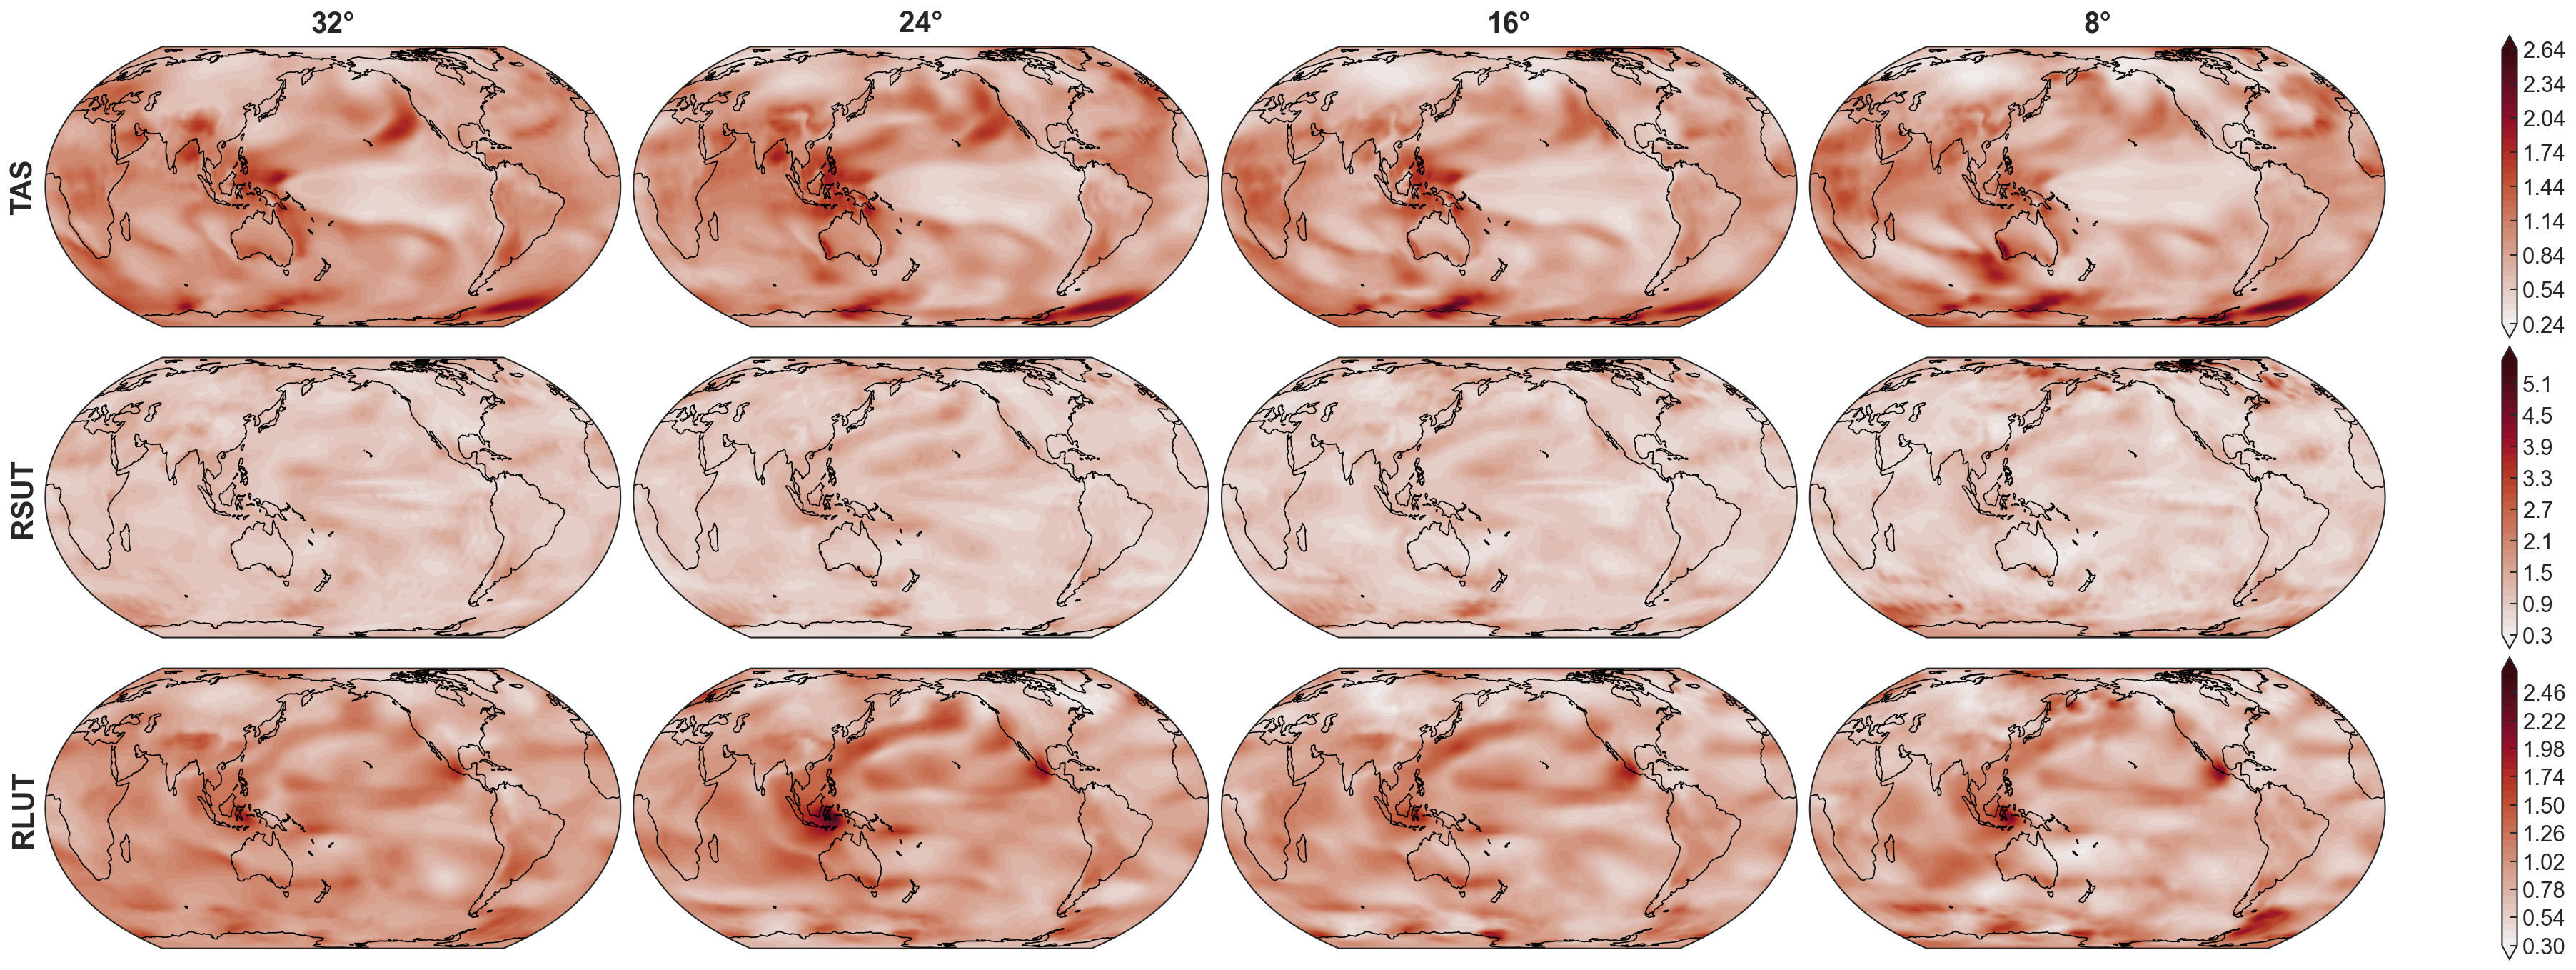

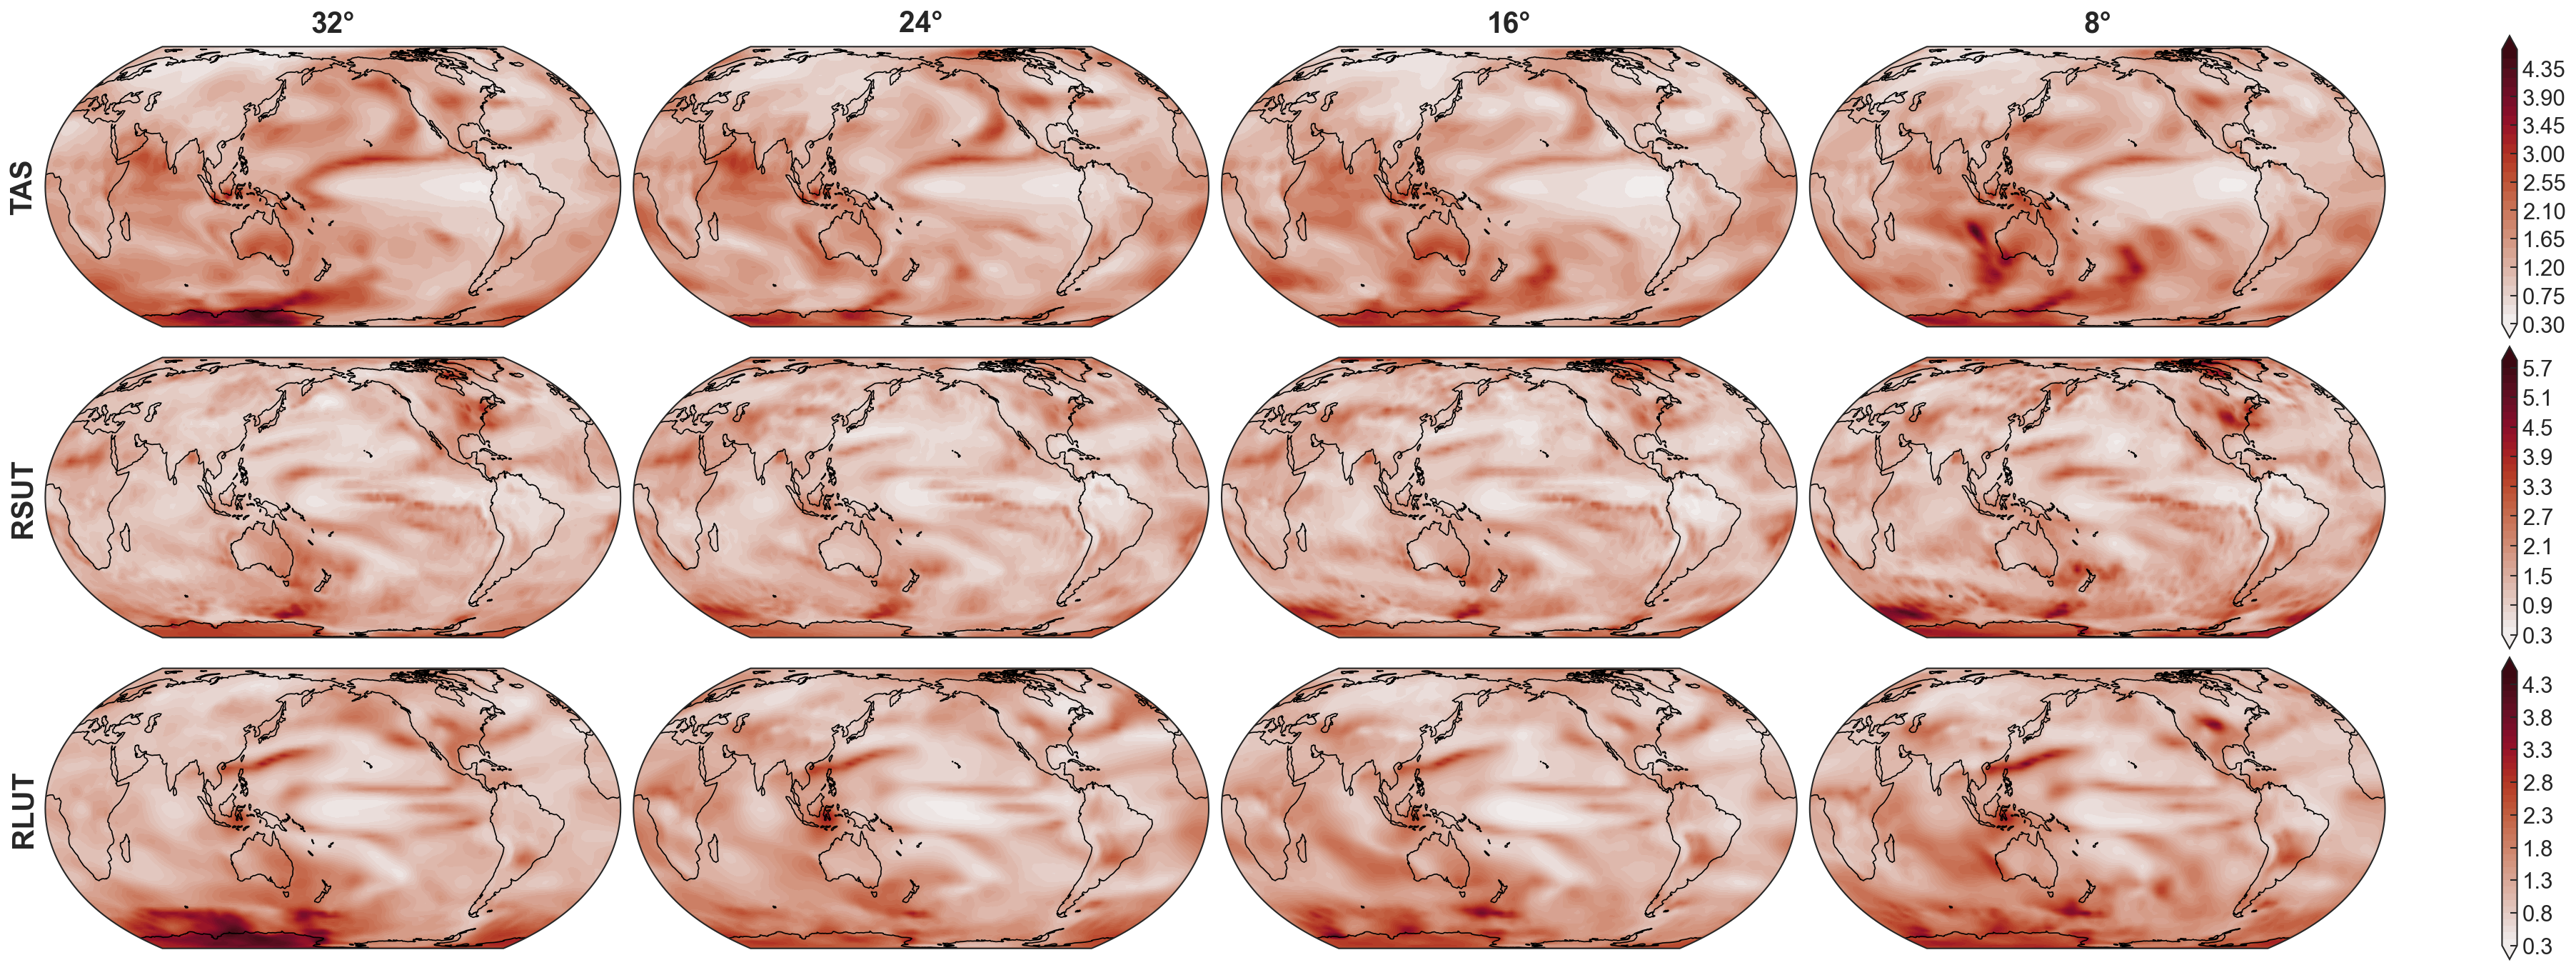

In [9]:
def plot_rmse_map(recons, ver, relative_rmse=True):
    fig, axs = plt.subplots(3, 4, figsize=(24, 9), subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)), dpi=150)

    for row, field in enumerate(["tas", "rsut", "rlut"]):
        plot_field(axs[row, :], [
            rmse(rec[field], ver[field], "time") / (ver[field].std("time") if relative_rmse else 1) for rec in recons.values()
        ], same_limits=False, cmap=cmocean.cm.amp, n_level=40, cbar_orientation="vertical")
    
    for ax in axs.flat:
        ax.coastlines()

    add_subplot_headers(["TAS", "RSUT", "RLUT"], [f"{res}°" for res in recons.keys()])

plot_rmse_map(recons_mpi, ver_mpi)
plot_rmse_map(recons_mri, ver_mri)